### First install dependencies, and configure GPU

%pip install --upgrade pip
%pip install tensorflow==2.10.0
%pip install numpy==1.24.3
%pip install opencv-python matplotlib
%pip list

In [34]:
import tensorflow as tf
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np 

In [35]:
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

### Remove any images that don't fit correct file types:

In [36]:
import cv2
import imghdr
import matplotlib.pyplot as plt

In [40]:
# Create a variable to store the name of the directory in which data is kept
data_dir = 'data'

# Create a list of image extensions we want to use 
image_extensions = ['jpeg', 'jpg', 'bmp', 'png']

In [124]:
#  RUN THIS CELL WITH IMSHOW UNCOMMENTED TO SEE IF READING IN AN IMAGE IS WORKING
# listdir shows the names of all the files in the directory of interest
os.listdir(os.path.join(data_dir, 'Chris'))
# Testing to see the output of the imread function
image = cv2.imread(os.path.join(data_dir, 'Chris', 'IMG_5841.jpg'))
# plt.imshow(image)

In [42]:
# Loop through each labelled directory and check each image
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_extensions:
                print('Image not in ext list {}'.format(image_path))
                # Remove the weird image from the folder if it doesn't have a matching extension
                os.remove(image_path)
        except Exception as e:
            print("Issue with image {}".format(image_path))

        

### Load Data In Using Keras Helper Function

In [44]:
# This helper function will build datasets given a set of data
# CHANGE THE BATCH_SIZE WHEN MORE IMAGES FOUND
data = tf.keras.utils.image_dataset_from_directory('data', batch_size = 6)

# Allows the use of numpy iterator functions which will help grab different batches
data_iterator = data.as_numpy_iterator()

Found 52 files belonging to 2 classes.


In [45]:
# Pulls a batch out of the iterator
batch = data_iterator.next()

In [125]:
#  This bit of code allows the batches to be checked, UNCOMMENT THE CODE BELOW THIS LINE TO SEE IF THE IMAGES HAVE READ IN
# fig, ax = plt.subplots(ncols = 2, figsize= (10,10))
# for idx, img in enumerate(batch[0][:2]):
#     ax[idx].imshow(img.astype(int))
#     ax[idx].title.set_text(batch[1][idx])

### Preprocessing (Scaling images; dividing into test, train and validation sets)

In [47]:
# Using a map in order to apply this function in pipeline
# Divide the first input by 255 (image values), and leave y (labels) unchanged
data = data.map(lambda x, y: (x / 255, y))

In [48]:
# This code allows the data to be checked in order to see if scaling has occuraed properly
scaled_iterator = data.as_numpy_iterator()
batch = scaled_iterator.next()

#### Divide data into training, testing a validation sets

In [53]:
len(data)
# train_size = int(len(data) * 0.7)
# validation_size = int(len(data) * 0.2) + 1
# test_size = int(len(data) * 0.1) + 1

train_size = 6
validation_size = 2
test_size = 1

In [54]:
# Making the training sets
train = data.take(train_size)
val = data.skip(train_size).take(validation_size)
test = data.skip(train_size + validation_size).take(test_size)

### Deep learning model part

In [56]:
#  Sequential works with one data input and one data ouput type problems, more complex problems can be done using the Functional API
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [58]:
# Establish an instance of a model 
model = Sequential()

In [62]:
# This has 16 filters, 3by3 pixels in size and it had a stride of 1 (how big the jumps are between pixels)
model.add(Conv2D(16, (3,3), strides=(1, 1), activation = 'relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), strides=(1, 1), activation = 'relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), strides=(1, 1), activation = 'relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

In [63]:
#  Adam is an optimizer, loss specifies as a long function, accuracy is how well you are classifying things
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics = ['accuracy'])

In [64]:
#  Note, the final layer has 257 parameters due to a bias term
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

### Training the model :)

In [65]:
logdir = 'logs'

In [66]:
# Allows the saving of a model at specific checkpoints
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [67]:
# Fitting the model on the training data, epochs is how long we train (1 epoch is 1 run over entire training set of data)
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
6/6 [==============================] - 19s 103ms/step - loss: 1.4473 - accuracy: 0.3889 - val_loss: 0.5213 - val_accuracy: 0.8333
Epoch 2/20
6/6 [==============================] - 1s 81ms/step - loss: 0.6968 - accuracy: 0.6111 - val_loss: 0.6421 - val_accuracy: 0.8333
Epoch 3/20
6/6 [==============================] - 1s 79ms/step - loss: 0.6413 - accuracy: 0.7500 - val_loss: 0.5882 - val_accuracy: 0.7500
Epoch 4/20
6/6 [==============================] - 1s 85ms/step - loss: 0.5260 - accuracy: 0.8333 - val_loss: 0.2586 - val_accuracy: 0.9167
Epoch 5/20
6/6 [==============================] - 1s 89ms/step - loss: 0.2550 - accuracy: 0.9167 - val_loss: 0.3177 - val_accuracy: 0.8333
Epoch 6/20
6/6 [==============================] - 1s 89ms/step - loss: 0.2638 - accuracy: 0.8611 - val_loss: 0.0935 - val_accuracy: 1.0000
Epoch 7/20
6/6 [==============================] - 1s 92ms/step - loss: 0.1049 - accuracy: 0.9722 - val_loss: 0.0546 - val_accuracy: 1.0000
Epoch 8/20
6/6 [=========

The loss and accuracy indicate the values on the training data, and the val_ equivalents indicate those values on the validation data

### We can plot the values stored in hist to visualize the improvement of the model

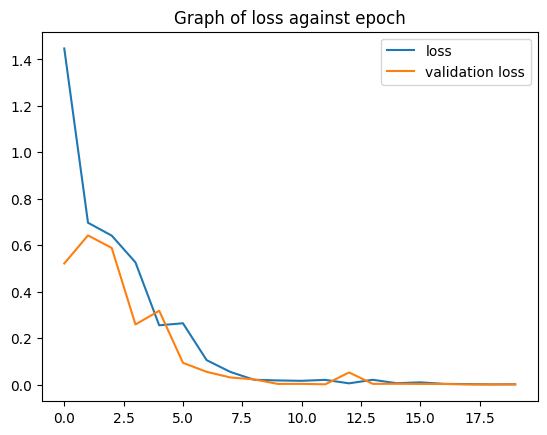

In [73]:
graph = plt.figure()
plt.plot(hist.history['loss'], label = 'loss')
plt.plot(hist.history['val_loss'], label = 'validation loss')
plt.legend()
plt.title("Graph of loss against epoch")
plt.show()

Things to note. If the val_loss increases, this can indicating overfitting. If there is little improvement, consider larger neural network or larger training data sets. val_loss tearing off may indicate a variance problem and would indicate the need for regularization.

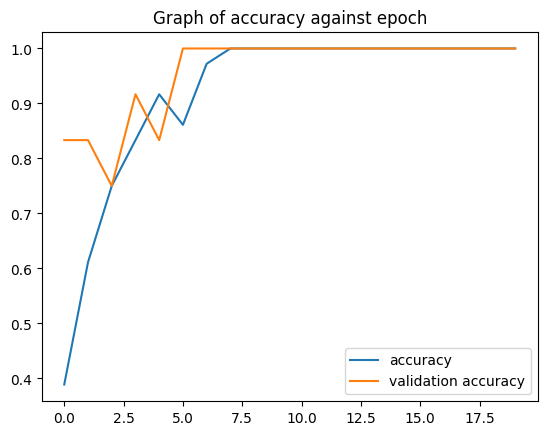

In [74]:
graph = plt.figure()
plt.plot(hist.history['accuracy'], label = 'accuracy')
plt.plot(hist.history['val_accuracy'], label = 'validation accuracy')
plt.legend()
plt.title("Graph of accuracy against epoch")
plt.show()

### Evaluating the performance of the model on the test data 

In [76]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [78]:
# Establish instances of the performance metrics 
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

In [85]:
#  Iterate through test set and evaulate performance metrics, metrics are between 0 and 1
for batch in test.as_numpy_iterator():
    X, y = batch 
    y_pred = model.predict(X)
    precision.update_state(y, y_pred)
    recall.update_state(y, y_pred)
    accuracy.update_state(y, y_pred)

print(precision.result())
print(recall.result())
print(accuracy.result())

1/1 [==============================] - 0s 12ms/step
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)


### Try the model out on a random image 


1/1 [==============================] - 0s 11ms/step


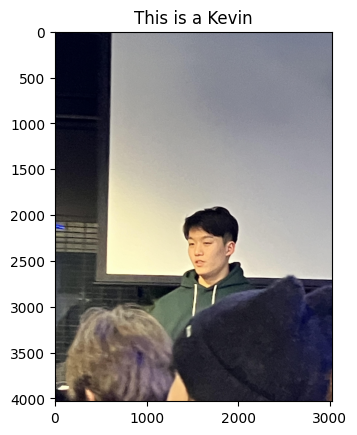

In [122]:
# File names to try:
# chris test 1.jpg
# kevin test 1.jpg
# chris test 2.jpg
# kevin test 2.jpg

files_names = {
    1: "chris test 1.jpg",
    2: "kevin test 1.jpg",
    3: "chris test 2.jpg",
    4: "kevin test 2.jpg"
}

file_name = input("Please enter the name of your image file: ")
img = cv2.imread(file_name)
resize_img = tf.image.resize(img, (256, 256))
prediction = model.predict(np.expand_dims(resize_img / 255, 0))

if (prediction > 0.5):
    title = "This is a Kevin"
elif (prediction < 0.5):
    title = "This is a Chris"

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title(title)
plt.show()


### Save model 

In [123]:
from tensorflow.keras.models import load_model
# h5 is a serialization format
model.save(os.path.join('models', 'KevinChris_1.0.h5'))

In [ ]:
# To load the model use:
# model = load_model(os.path.join('models', 'KevinChris_1.0.h5'))